In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df_initial = pd.read_csv('./data.csv',encoding='latin1',dtype={'CustomerID': str,'InvoiceID': str})
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
print('Dataframe dimensions:', df_initial.shape)

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'}))
print(tab_info)

In [3]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [21]:
# Remove entries for customer ID NULL
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'}))
print(tab_info)

Dataframe dimensions: (406829, 8)
                 InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0           0        0               0   
null values (%)        0.0       0.0         0.0      0.0             0.0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0          0       0  
null values (%)        0.0        0.0     0.0  


In [22]:
df_initial.drop_duplicates(inplace = True)

In [23]:
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (401604, 8)


In [24]:
country_to_index = {}
count=0
countries = df_initial["Country"].to_numpy()
for i in range(countries.shape[0]):
    if countries[i] not in country_to_index:
        country_to_index[countries[i]] = count
        count+=1
print(count)
print(country_to_index)

37
{'United Kingdom': 0, 'France': 1, 'Australia': 2, 'Netherlands': 3, 'Germany': 4, 'Norway': 5, 'EIRE': 6, 'Switzerland': 7, 'Spain': 8, 'Poland': 9, 'Portugal': 10, 'Italy': 11, 'Belgium': 12, 'Lithuania': 13, 'Japan': 14, 'Iceland': 15, 'Channel Islands': 16, 'Denmark': 17, 'Cyprus': 18, 'Sweden': 19, 'Austria': 20, 'Israel': 21, 'Finland': 22, 'Greece': 23, 'Singapore': 24, 'Lebanon': 25, 'United Arab Emirates': 26, 'Saudi Arabia': 27, 'Czech Republic': 28, 'Canada': 29, 'Unspecified': 30, 'Brazil': 31, 'USA': 32, 'European Community': 33, 'Bahrain': 34, 'Malta': 35, 'RSA': 36}


In [25]:
df_initial = df_initial.drop("Country", 1)

/tmp/ipykernel_6946/543043970.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_initial = df_initial.drop("Country", 1)


In [9]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850


In [26]:
for i in range(countries.shape[0]):
    countries[i] = country_to_index[countries[i]]
df_initial["CountryID"] = countries
df_initial.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,CountryID
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,1
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,1
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,1
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,1
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,1


In [27]:
df_phase2 = df_initial
df_phase2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,CountryID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,0
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,1
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,1
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,1
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,1


In [28]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [14]:
# Grouping Rows if they belong to same invoice no and customer id
temp = df_phase2.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


In [16]:
df_cleaned = df_phase2.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] 
doubtfull_entry = []

for index, col in  df_phase2.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_phase2[(df_phase2['CustomerID'] == col['CustomerID']) &
                         (df_phase2['StockCode']  == col['StockCode']) & 
                         (df_phase2['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_phase2['Quantity']   > 0)].copy()

    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)

    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        

    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break        

In [29]:
print(len(doubtfull_entry))

1226


In [30]:
df_cleaned.drop(entry_to_remove,axis=0,inplace=True)
df_cleaned.drop(doubtfull_entry,axis=0,inplace=True)

In [77]:
print(df_cleaned.shape)

(392857, 11)


In [78]:
df_phase3 = df_cleaned

In [79]:
df_phase3["TotalPrice"] = df_phase3["UnitPrice"]*(df_phase3["Quantity"] - df_phase3["QuantityCanceled"])
df_phase3

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,CountryID,QuantityCanceled,TotalPrice,prod_cat
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,0,0,15.30,4
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,0,0,20.34,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,0,0,22.00,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,0,0,20.34,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,0,0,20.34,2
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,1,0,10.20,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,1,0,12.60,4
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,1,0,16.60,2
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,1,0,16.60,2


In [ ]:
temp = df_phase3.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
basket_price = basket_price[basket_price["Basket Price"]>0]
basket_price.head()

In [ ]:
df_phase4 = pd.read_csv('basket_price.csv', encoding = 'latin1')
df_phase4

In [34]:
df_phase3.to_csv("df_phase3.csv")

In [35]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
lem = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /home/vaibhav/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vaibhav/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/vaibhav/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
root_freq = {}
stock_to_roots = {}
root_to_index = {}
count = 0

def is_noun(pos):
    if pos[:2] == 'NN':
        return True
    return False


for i, row in df_phase3.iterrows():
    if pd.isnull(desc):
        continue 
    desc = row["Description"]
    desc = desc.lower()
    stock = row["StockCode"]
    tokens = nltk.word_tokenize(desc)
    nouns = [word for (word, pos) in nltk.pos_tag(tokens) if is_noun(pos)] 
    vis = {}
    temp = []
    for noun in nouns:
        noun = noun.lower()
        root = lem.lemmatize(noun)
        if root not in root_freq:
            root_freq[root] = 1
            vis[root] = 1
            temp.append(root)
            root_to_index[root] = count 
            count += 1
        elif root not in vis:
            root_freq[root] += 1
            vis[root] = 1
            temp.append(root)
    stock_to_roots[stock] = temp

print(root_freq)

In [46]:
threshold = 1400
print(len(root_freq))
top_roots = {key:val for key, val in root_freq.items() if val >= threshold}
print(len(top_roots))

1499
185


In [ ]:
c = 0
pop_root_to_index = {}
for key, val in top_roots.items():
    pop_root_to_index[key] = c 
    c += 1
print(pop_root_to_index)

In [48]:
list_products = df_phase3["StockCode"].unique()

In [49]:
products_np = []
mean_prices = []
count_cat = [0 for _ in range(6)]
for i,stock in enumerate(list_products):
    desc = df_phase3[df_phase3["StockCode"] == stock]["Description"].iloc[0]
    temp = [stock, desc]
    roots = stock_to_roots[stock]
    t = [0 for i in range(len(top_roots))]
    for root in roots:
        if root in top_roots:
            index = pop_root_to_index[root]
            t[index] = 1
    temp.extend(t)
    mean_price = df_phase3[df_phase3["StockCode"] == stock]["UnitPrice"].mean()
    prod_cat = 0

    if mean_price < 1:
        prod_cat = 0
    elif mean_price < 2:
        prod_cat = 1
    elif mean_price < 3:
        prod_cat = 2
    elif mean_price < 5:
        prod_cat = 3
    elif mean_price < 10:
        prod_cat = 4
    else:
        prod_cat = 5

    cat_list = [0 for _ in range(6)]
    cat_list[prod_cat] = 1
    temp.extend(cat_list)
    mean_prices.append(mean_price)
    count_cat[prod_cat]+=1
    temp = np.array(temp)
    # print(temp.shape)
    products_np.append(temp)

0.00075


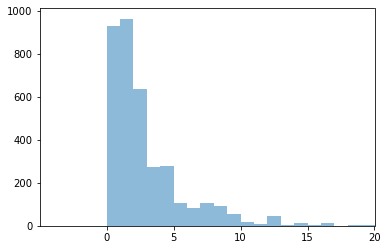

In [50]:
bins = np.arange(-100, 100, 1) # fixed bin size
print(min(mean_prices))
plt.xlim([min(mean_prices)-5, 20])

plt.hist(mean_prices, bins=bins, alpha=0.5)
plt.show()



In [51]:
count_cat = np.array(count_cat)
for i in range(6):
    print(count_cat[i]/np.sum(count_cat) * 100, "%")


25.340971085651937 %
26.29569012547736 %
17.321331151118386 %
15.057283142389524 %
11.947626841243862 %
4.037097654118931 %


In [52]:
products_np = np.array(products_np)
print(products_np.shape)

(3666, 193)


In [54]:
cols = ["StockCode","Description"]
for i in range(185):
    cols.append("root-"+str(i+1))
for i in range(6):
    cols.append("priceRange-"+str(i+1))
df_products = pd.DataFrame(products_np,columns = cols)
df_products.to_csv("df_products.csv")

In [55]:
df_inp = df_products.drop(["StockCode","Description",df_products.columns[0]],axis=1)
prod_np = df_inp.to_numpy().astype('int64')


In [56]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters = 5, n_init=1000)
kmeans.fit(prod_np)
clusters = kmeans.predict(prod_np)

print(clusters)

[4 2 2 ... 0 0 4]


In [57]:
print(pd.Series(clusters).value_counts())

3    964
0    929
4    635
1    586
2    552
dtype: int64


In [58]:
print(df_phase3.shape,len(clusters))

(392857, 10) 3666


In [59]:
df_phase4 = df_products[["StockCode", "Description"]]
df_phase4["Category"] = clusters
print(df_phase4 )

     StockCode                          Description  Category
0       85123A   WHITE HANGING HEART T-LIGHT HOLDER         4
1        71053                  WHITE METAL LANTERN         2
2       84406B       CREAM CUPID HEARTS COAT HANGER         2
3       84029G  KNITTED UNION FLAG HOT WATER BOTTLE         2
4       84029E       RED WOOLLY HOTTIE WHITE HEART.         2
...        ...                                  ...       ...
3661    90214U            LETTER "U" BLING KEY RING         0
3662    90214W            LETTER "W" BLING KEY RING         0
3663    90214Z            LETTER "Z" BLING KEY RING         0
3664     90089       PINK CRYSTAL SKULL PHONE CHARM         0
3665     23843          PAPER CRAFT , LITTLE BIRDIE         4

[3666 rows x 3 columns]


/tmp/ipykernel_6946/3665360597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_phase4["Category"] = clusters


In [60]:
df_phase4.to_csv("final_prod_cat.csv")

In [ ]:
stock_to_cat = {}

for i,row in df_phase4.iterrows():
    stock_to_cat[row["StockCode"]] = row["Category"]

print(stock_to_cat)

In [82]:
stock_list = df_phase3["StockCode"].to_numpy()
cat_list = []
for i in range(stock_list.shape[0]):
    cat_list.append(stock_to_cat[stock_list[i]])

df_phase3["prod_cat"] = cat_list



In [81]:
df_phase3_np = df_phase3.to_numpy()

In [ ]:
print(df_phase3)

In [ ]:
df_phase5 = []
for i in range(df_phase3_np.shape[0]):
    temp = [0,0,0,0,0]
    cat = df_phase3_np[i][-1]
    temp[cat] = df_phase3_np[i][-2]
    res = list(df_phase3_np[i]) + temp
    df_phase5.append(np.array(res))

df_phase5_np = np.array(df_phase5)
print(df_phase5_np)



In [ ]:
cols = list(df_phase3.columns)
cols.extend(["cat0","cat1","cat2","cat3","cat4"])
df_phase6 = pd.DataFrame(df_phase5_np,columns=cols)
print(df_phase6)

In [85]:
df_phase6.to_csv("df_phase6.csv")

In [ ]:
invoice_to_cats = {}
for i, row in df_phase6.iterrows():
    invoice = row["InvoiceNo"]
    if invoice in invoice_to_cats:
        invoice_to_cats[invoice][3] += row["cat0"]
        invoice_to_cats[invoice][4] += row["cat1"]
        invoice_to_cats[invoice][5] += row["cat2"]
        invoice_to_cats[invoice][6] += row["cat3"]
        invoice_to_cats[invoice][7] += row["cat4"]
        invoice_to_cats[invoice][8] += row["TotalPrice"]
    else:
        invoice_to_cats[invoice]= list([row["CustomerID"],row["InvoiceNo"], row["CountryID"], row["cat0"],row["cat1"],row["cat2"],row["cat3"],row["cat4"],row["TotalPrice"] ])

print(invoice_to_cats)

In [ ]:
df_phase7 = []
for key, val in invoice_to_cats.items():
    df_phase7.append(val)

print(df_phase7)

In [ ]:
cust_to_invoice = {}

for i, row in enumerate(df_phase7):
    cust = row[0]
    if cust in cust_to_invoice:
        cust_to_invoice[cust][2] += row[3]
        cust_to_invoice[cust][3] += row[4]
        cust_to_invoice[cust][4] += row[5]
        cust_to_invoice[cust][5] += row[6]
        cust_to_invoice[cust][6] += row[7]
        cust_to_invoice[cust][7] += row[8]
    else:
        cust_to_invoice[cust]= list([row[0], row[2], row[3],row[4],row[5],row[6],row[7],row[8]])

print(cust_to_invoice)

In [ ]:
df_phase8 = []
for key, val in cust_to_invoice.items():
    df_phase8.append(val)

print(df_phase8)

In [112]:
cols = ["CustomerID", "CountryID", "Category-0", "Category-1", "Category-2", "Category-3", "Category-4", "Total Expenditure"]
df_phase9 = pd.DataFrame(df_phase8, columns = cols)
print(df_phase9)

     CustomerID  CountryID  Category-0  Category-1  Category-2  Category-3  \
0         17850          0        0.00     1860.65     1873.79      386.90   
1         13047          0      277.18      888.15      921.00      478.83   
2         12583          1     1437.83     1033.50     2077.95     1496.86   
3         13748          0       52.68      123.05       48.20      147.00   
4         15100          0        0.00      635.10        0.00        0.00   
...         ...        ...         ...         ...         ...         ...   
4334      13436          0       20.70       83.35       45.80       11.70   
4335      15520          0       53.40        0.00        9.90       94.56   
4336      13298          0        0.00        0.00      360.00        0.00   
4337      14569          0        0.00       24.90       63.09        3.60   
4338      12713          4       91.06      125.70      233.05      317.10   

      Category-4  Total Expenditure  
0        1201.50         